<a href="https://colab.research.google.com/github/Vanpersact/hello-world/blob/main/1-Analise_Completa_Manifestacoes_CPTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 Instalar bibliotecas necessárias
!pip install wordcloud pandas matplotlib seaborn openpyxl plotly


In [2]:
# 📚 Importação de bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict, Counter
import os
import plotly.express as px
from datetime import datetime


In [3]:
# 📁 Carregamento da base de dados
arquivo = '/content/Manifestacoes_Abril2025.xlsx'
df = pd.read_excel(arquivo)


In [4]:
# 🛠️ Ajuste de colunas caso o cabeçalho esteja na linha 2
if df.columns[0] != 'COD_MANIFESTACAO':
    df.columns = df.iloc[0]
    df = df[1:]
    df.columns.name = None


In [5]:
# 🏷️ Renomear colunas principais
df = df.rename(columns={
    "COD_MANIFESTACAO": "COD_MANIFESTACAO",
    "MOTIVO": "MOTIVO",
    "DATA_MANIF": "DATA_MANIF",
    "DIA_SEM": "DIA_SEM",
    "DATA_OCOR": "DATA_OCOR",
    "HORA_OCOR": "HORA_OCOR",
    "LOCAL_REF": "LOCAL_REF",
    "DESCRIÇÃO": "DESCRICAO",
    "CLASSIFICACAO_MANIF": "CLASSIFICACAO_MANIF",
    df.columns[-1]: "LINHA"
})


In [6]:
# ⏱️ Conversão de tipos
df["DATA_MANIF"] = pd.to_datetime(df["DATA_MANIF"], errors='coerce')
df["DATA_OCOR"] = pd.to_datetime(df["DATA_OCOR"], errors='coerce')
df["HORA_OCOR"] = pd.to_numeric(df["HORA_OCOR"], errors='coerce')


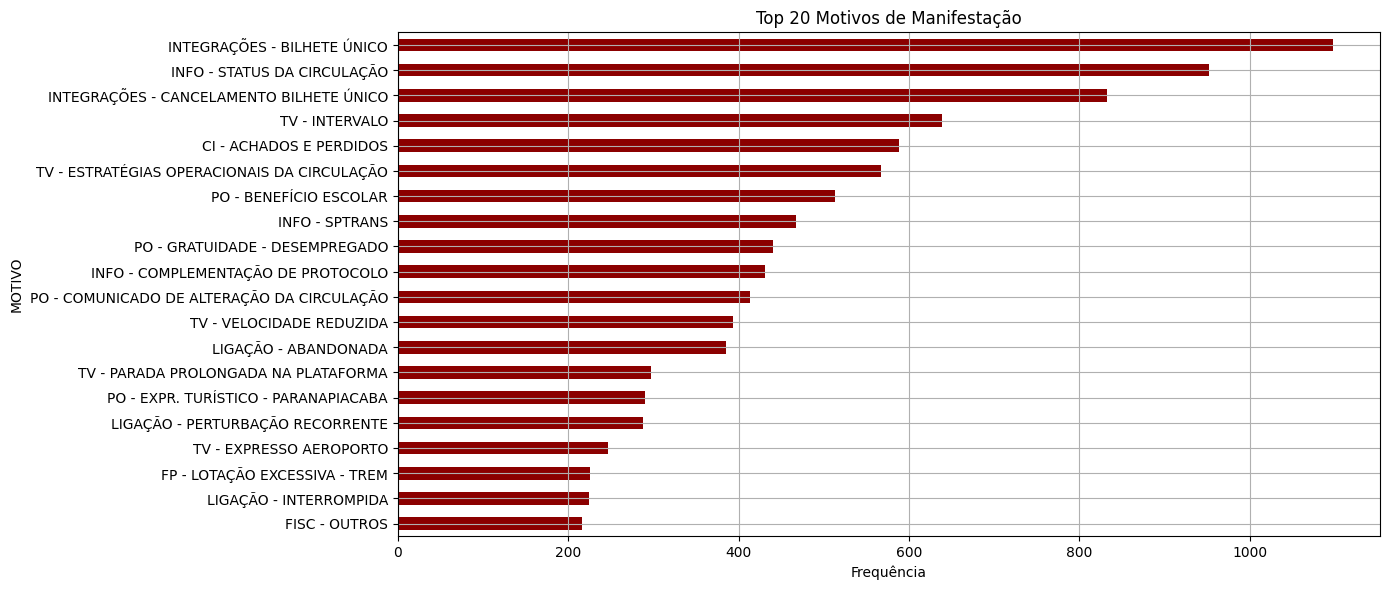

In [7]:
# 📊 Top 15 motivos de manifestação
plt.figure(figsize=(14, 6))
df["MOTIVO"].value_counts().nlargest(20).plot(kind='barh', color='darkred')
plt.title("Top 20 Motivos de Manifestação")
plt.xlabel("Frequência")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2279681596.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="DIA_SEM", order=dias_ordenados, palette="Reds")


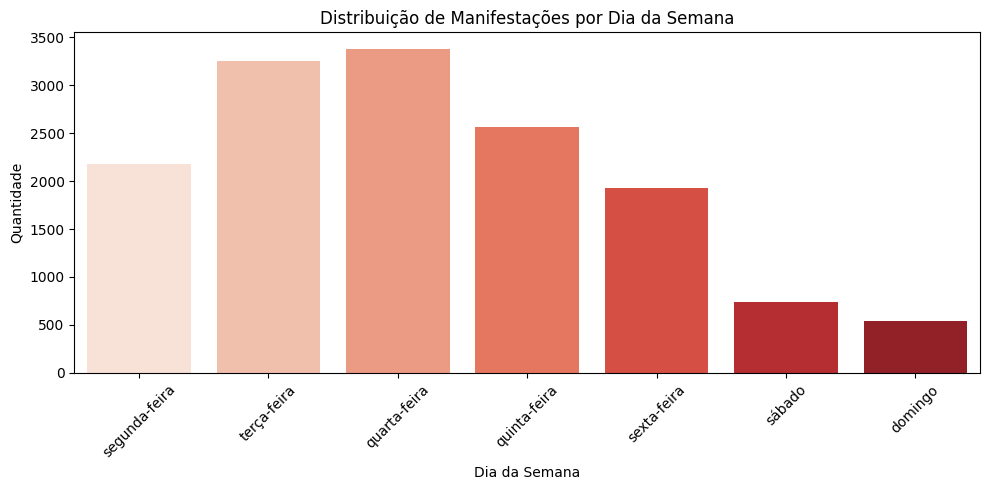

In [8]:
# 📅 Distribuição por dia da semana
dias_ordenados = ['segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado', 'domingo']
df["DIA_SEM"] = df["DIA_SEM"].str.lower()
df["DIA_SEM"] = pd.Categorical(df["DIA_SEM"], categories=dias_ordenados, ordered=True)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="DIA_SEM", order=dias_ordenados, palette="Reds")
plt.title("Distribuição de Manifestações por Dia da Semana")
plt.ylabel("Quantidade")
plt.xlabel("Dia da Semana")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3332646970.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index="HORA_OCOR", columns="DIA_SEM", aggfunc="size", fill_value=0)


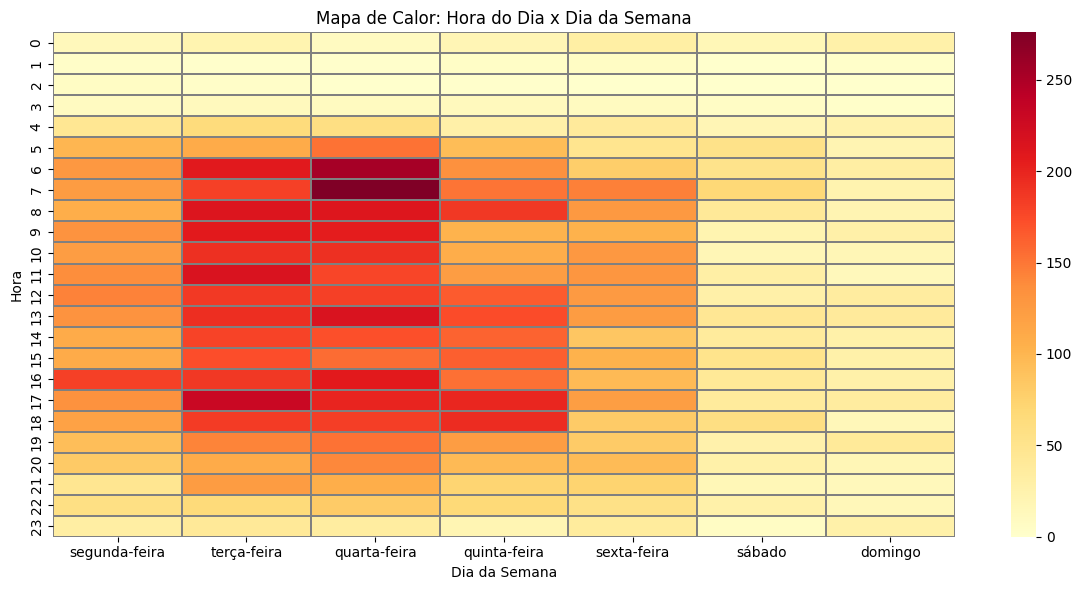

In [9]:
# 🔥 Mapa de calor por hora e dia
pivot = df.pivot_table(index="HORA_OCOR", columns="DIA_SEM", aggfunc="size", fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.3, linecolor='gray')
plt.title("Mapa de Calor: Hora do Dia x Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Hora")
plt.tight_layout()
plt.show()


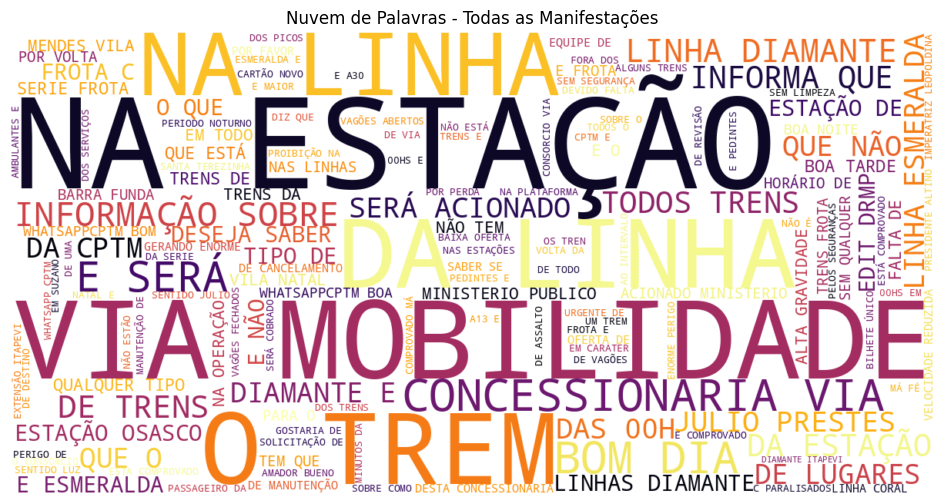

In [10]:
# ☁️ Nuvem de palavras geral (todas as manifestações)
texto = " ".join(df["DESCRICAO"].dropna().astype(str).tolist())
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='inferno', max_words=150).generate(texto)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras - Todas as Manifestações")
plt.show()


In [11]:
# 🎯 Foco em reclamações - apenas adjetivos (simulados)
df_reclamacoes = df[df["CLASSIFICACAO_MANIF"].str.upper() == "RECLAMAÇÃO"].copy()

adjetivos_exemplo = [
    'lento', 'sujo', 'barulhento', 'quente', 'frio', 'perigoso', 'velho', 'lotado', 'demorado',
    'inseguro', 'desconfortável', 'escuro', 'caro', 'úmido', 'horrível', 'ruim', 'péssimo',
    'fraco', 'frágil', 'instável', 'precário', 'ineficiente', 'insuficiente', 'revoltante',
    'desumano', 'inaceitável', 'desagradável', 'injusto', 'problemático', 'difícil', 'caótico',
    'quebrado', 'falho', 'irregular', 'frequente', 'inconstante', 'baixa', 'curto', 'agressivo',
    'confuso', 'degradante', 'frustrante', 'impróprio', 'inadequado', 'insuportável', 'lamentável',
    'mofado', 'obsoleto', 'pobre', 'saturado', 'sofrido', 'sufocante', 'tenso', 'triste', 'vazio',
    'interminável', 'irresponsável', 'inoperante', 'defeituoso', 'danificado', 'parado', 'pior'
]
adjetivos_set = set([a.lower() for a in adjetivos_exemplo if len(a) >= 3])

adjetivos_linha = defaultdict(list)
for linha in df_reclamacoes["LINHA"].unique():
    descricoes = df_reclamacoes[df_reclamacoes["LINHA"] == linha]["DESCRICAO"].dropna().astype(str).tolist()
    palavras = " ".join(descricoes).lower().split()
    palavras_filtradas = [p for p in palavras if p in adjetivos_set]
    adjetivos_linha[linha] = palavras_filtradas

output_folder = "/content/nuvens_adjetivos"
os.makedirs(output_folder, exist_ok=True)

for linha, lista_adjetivos in adjetivos_linha.items():
    if len(lista_adjetivos) < 5:
        continue
    texto_final = " ".join(lista_adjetivos)
    wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='inferno', max_words=100).generate(texto_final)
    wordcloud.to_file(os.path.join(output_folder, f"{linha.replace(' ', '_')}.png"))


In [12]:
# 📊 Ranking completo de adjetivos por linha
ranking_completo = []
for linha, lista_adjetivos in adjetivos_linha.items():
    contagem = Counter(lista_adjetivos)
    for adjetivo, freq in contagem.items():
        ranking_completo.append({
            "Linha": linha,
            "Adjetivo": adjetivo,
            "Frequência": freq
        })

df_ranking = pd.DataFrame(ranking_completo).sort_values(by=["Linha", "Frequência"], ascending=[True, False])
df_ranking.to_excel("/content/adjetivos_por_linha.xlsx", index=False)

print("✅ Tudo pronto! Arquivos gerados:")
print("- 📁 Nuvens salvas em: /content/nuvens_adjetivos")
print("- 📊 Ranking salvo em: /content/adjetivos_por_linha.xlsx")


✅ Tudo pronto! Arquivos gerados:
- 📁 Nuvens salvas em: /content/nuvens_adjetivos
- 📊 Ranking salvo em: /content/adjetivos_por_linha.xlsx
